/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


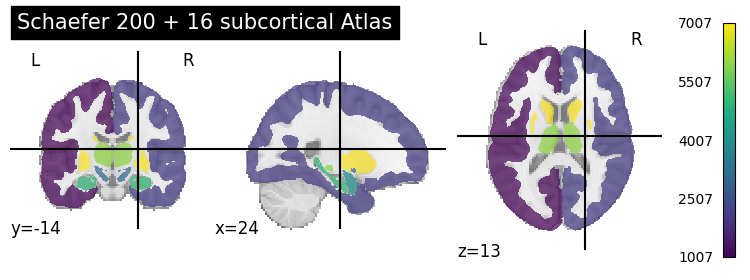

In [1]:
from nilearn.image import resample_to_img
from nilearn import plotting
import nibabel as nib
import pandas as pd
import numpy as np
from scipy.io import loadmat

# Load the combined schaefer atlas (abend) image 
atlas_img = nib.load(f"/mnt/fast_scratch/Atlases/atlas_abend200/atlas_schaefer200_7net_3d.nii.gz")

# labels for atlas
labels_coords = pd.read_csv('/mnt/fast_scratch/Atlases/atlas_abend200/abend216_mnicoords_AtlasLabels.csv')
labels_coords_short = pd.read_csv('~/Git/BodyWanderingCCA/data/abend216_yeo7+InteroNetwork.csv')

# Plot the atlas
plotting.plot_roi(atlas_img, cmap='viridis', colorbar=True, title=f'Schaefer 200 + 16 subcortical Atlas')
plotting.show()

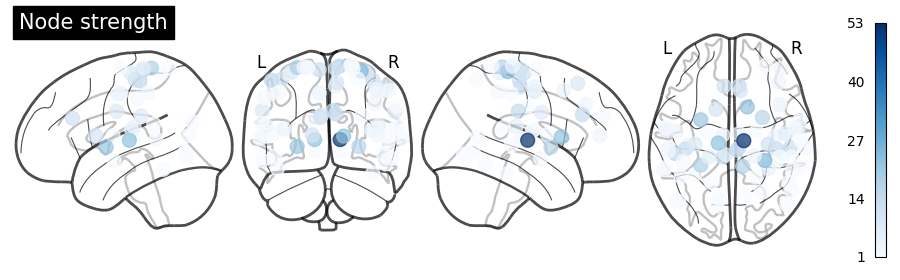

In [2]:
# load CCA result
cca_mat = loadmat(f"/home/leah/Git/BodyWanderingCCA/figures/CCA_BWitems/brainloadings.mat") 
fmri_loadings = cca_mat["weightX"]
n_areas= 216
n_components=1

# rearrange brain loadings into cor_mat dimensions
idx = np.tril_indices(n_areas, k=-1)
corr_mat = np.zeros((n_areas, n_areas, n_components))
for i in range(n_components):
    this_mat = np.zeros((n_areas, n_areas))
    this_mat[idx] = fmri_loadings[:,i] 
    corr_mat[..., i] = this_mat + this_mat.T

# define which regions cross threshold
percentile = 99
threshold = np.percentile(np.abs(corr_mat[:, :, i]), percentile) # 99 percentile threshold
sum_of_connections = (np.abs(corr_mat[:, :, i]) > threshold).sum(axis=1)

# plot regions which cross threshold 
labels_coords['combined_coords'] = labels_coords.apply(lambda row: (row['mnicoordsX'], row['mnicoordsY'], row['mnicoordsZ']), axis=1)
labels_coords['combined_coords'] = [tuple(round(coord, 0) for coord in item) for item in labels_coords['combined_coords']] # make rounded combined mni coords col 

n_connections = 0 # np.percentile(np.abs(sum_of_connections), percentile) # additional threshold for sums (only plots if sums are above this)
this_coordinates = np.array(list(labels_coords['combined_coords'][sum_of_connections > n_connections]))
this_sum = sum_of_connections[sum_of_connections > n_connections]

plotting.plot_markers(
    node_coords=this_coordinates,
    node_values=this_sum,
    title=f"Node strength",
    node_cmap="Blues",
    display_mode="lyrz"
)

In [3]:
# gradient averages for each of the top 1% cca brain regions

# Get the selected parcel numbers of top 1% of cca brain results
selected_parcels = labels_coords.loc[sum_of_connections > n_connections, 'parcelnum'].tolist() # numbers of parcels
# get matrix data of atlas
parcel_data = atlas_img.get_fdata()

df = pd.DataFrame()
df['ParcelNum'] = selected_parcels
# loop for each gradient nifti
for gradient_num in range(5):
    # load gradient
    gradient = nib.load(f"/home/leah/Git/BodyWanderingCCA/data/gradients/volume.all.{gradient_num}.nii.gz")

    # resample gradients to be same space as atlas
    gradients_resampled = resample_to_img(gradient, atlas_img)
    gradients_data = gradients_resampled.get_fdata()

    # Find gradient values in the selected parcel & average
    average_gradient = {}
    for parcel_num in selected_parcels:
        average_gradient[parcel_num] = np.mean(gradients_data[parcel_data == parcel_num]) 
    
    # Append the averaged gradient result to the DataFrame    
    df[f'Gradient{gradient_num}'] = df['ParcelNum'].map(average_gradient) #df[f'Gradient{gradient_num}'] = average_gradient
        
df['short_labels'] = df['ParcelNum'].map(labels_coords_short[sum_of_connections > n_connections].set_index('parcelnum')['short_labels'])
#df.to_csv('/home/leah/Git/BodyWanderingCCA/data/gradients/gradient_averages_cca.csv', index=False)